This notebook fits the diffraction geometry + module geometry to a series of powder patterns (with different beam centers)

In [1]:
import time
start = time.time()
import pylab as pl, numpy as np, os
from glob import glob
from ImageD11 import transform
from ImageD11.transformer import transformer
from ImageD11.parameters import read_par_file
from ImageD11.columnfile import columnfile
import h5py
from scipy.optimize import curve_fit
import fabio
%matplotlib inline

In [2]:
w = 0.6943698 #edit here
12.39842/w # approximate energy


17.855644067469523

In [3]:
files = glob('pilatusSpatial/*p.par')
flts = [file.replace('.par','.flt') for file in files]
cbfs = glob('lab6/*.cbf')
print(cbfs)

# The par files need to be manually created ... ?
#  ... done in ImageD11_gui.py
#
# ... then all iterated using fitted parameters as a starting point
for file in files:
    # initial 
    p = read_par_file(file)
#    p = read_par_file("eigerSpatial/%ds.par"%(i)) # s = spatial
    print(file,p.get('y_center'),p.get('z_center'))
a0 = p.get('cell__a')
print(a0)

['lab6\\lab6_000_-80_0001p.cbf', 'lab6\\lab6_000_00_0001p.cbf', 'lab6\\lab6_100_-80_0001p.cbf', 'lab6\\lab6_100_00_0001p.cbf', 'lab6\\lab6_200_00_0001p.cbf', 'lab6\\lab6_300_00_0001p.cbf']
pilatusSpatial\lab6_000_-80_0001p.par 719.9262471306008 1194.8714654963799
pilatusSpatial\lab6_000_00_0001p.par 719.6710954274424 1660.2933737518072
pilatusSpatial\lab6_100_-80_0001p.par 720.000637294442 1194.821749569254
pilatusSpatial\lab6_100_00_0001p.par 719.6964090413462 1659.9388356828035
pilatusSpatial\lab6_200_00_0001p.par 719.6935547893349 1659.9064073079587
pilatusSpatial\lab6_300_00_0001p.par 719.6028161107671 1659.8286210276224
4.156826


In [4]:
cbf = fabio.open(cbfs[0]).data #make this an array of an image from your detector

#this cbfhead section may need to be changed if you have a different header format
#just to extract pixel sizes, which you probably already know anyway,
#then just set pixy and pixz to those values manually


#cbfhead = fabio.open(cbfs[0]).header
#cbfdata = cbfhead["_array_data.header_contents"].replace('\r','').split('\n')
#for item in cbfdata:
#    if 'Pixel_size' in item:
#        pixy = round(float(item.split(' ')[2])*1000,3) #x 1000 to convert to mm
#        pixz = round(float(item.split(' ')[5])*1000,3)
#        break
######
pixy = 0.172 #input your values here
pixz = 0.172
    
y,x = np.where(cbf == -1) #change this condition if gaps are defined differently
cbfysize = len(cbf)
cbfxsize = len(cbf[0])
print(f'xsize = {cbfxsize}, ysize = {cbfysize}')


xgaps = []
ygaps = []


for i in set(x):
    if len(np.where(x==i)[0]) == cbfysize:
        xgaps.append(i)
for i in set(y):
    if len(np.where(y==i)[0]) == cbfxsize:
        ygaps.append(i)



xgapedge = []
ygapedge = []

lengapx = 0
lengapy = 0

xgapfound = False
ygapfound = False



fo = [0]
so = [0]
gapno = 0



for i in range(len(xgaps[1:])+1):
    lengapx += 1
    if xgaps[i] != xgaps[i-1] + 1:
        xgapedge.append(xgaps[i])
        
        gapno += 1
        fo.append(lengapx)
        #if i > 0:
         #   xgapfound = True
    elif xgaps[i] == xgaps[i-1]+1: 
        fo[gapno] += 1

gapno = 0
for i in range(len(ygaps[1:])+1):
    lengapy += 1
    if ygaps[i] != ygaps[i-1] + 1:
        ygapedge.append(ygaps[i])
        gapno += 1
        so.append(lengapy)
    elif ygaps[i] == ygaps[i-1]+1:
        so[gapno] += 1
print(f'x gap edges = {xgapedge}, y gap edges = {ygapedge}')






#print(lengapx,lengapy)
noxmodules = len(xgapedge) + 1
noymodules = len(ygapedge) + 1
no_modules = noxmodules*noymodules
print(f'no. modules = {noxmodules}x{noymodules} = {no_modules} total')

fs = xgaps[0]
ss = ygaps[0]
print(f'module size = {fs}x{ss}')


fo = np.array(fo)
so = np.array(so)
ygapsizes = [so[i]-so[i-1] for i in range(1,len(so))]
xgapsizes = [fo[i]-fo[i-1] for i in range(1,len(fo))]


print(f'slow offsets = {so}, fast offsets = {fo}')

noChipsx = 8 #change these for different chip layouts. Pilatus 2m Si appears to be 8x2
noChipsy = 2 #for Pilatus 2m CdTe it is 4x2 as modules divided into 2 submodules with 1 pixel gap in between

virtualLinesx = []
virtualLinesy = []
for l in range(len(fo)):
    for i in range(1,noChipsx):
        virtualLinePosx = i*(fs-1)//noChipsx
        virtualLinesx.append(fs*l + fo[l] + virtualLinePosx)
for l in range(len(so)):
    for i in range(1,noChipsy):
        virtualLinePosy = i*(ss-1)//noChipsy
        virtualLinesy.append(ss*l + so[l] + virtualLinePosy)
print(f'virtual lines x = {virtualLinesx}')
print(f'virtual lines y = {virtualLinesy}')

xsize = 1475, ysize = 1679
x gap edges = [487, 981], y gap edges = [195, 407, 619, 831, 1043, 1255, 1467]
no. modules = 3x8 = 24 total
module size = 487x195
slow offsets = [  0  17  34  51  68  85 102 119], fast offsets = [ 0  7 14]
virtual lines x = [60, 121, 182, 243, 303, 364, 425, 554, 615, 676, 737, 797, 858, 919, 1048, 1109, 1170, 1231, 1291, 1352, 1413]
virtual lines y = [97, 309, 521, 733, 945, 1157, 1369, 1581]


In [5]:
frms = np.arange(1,len(files)+1,dtype = np.uint8)#[1,2,3,4]

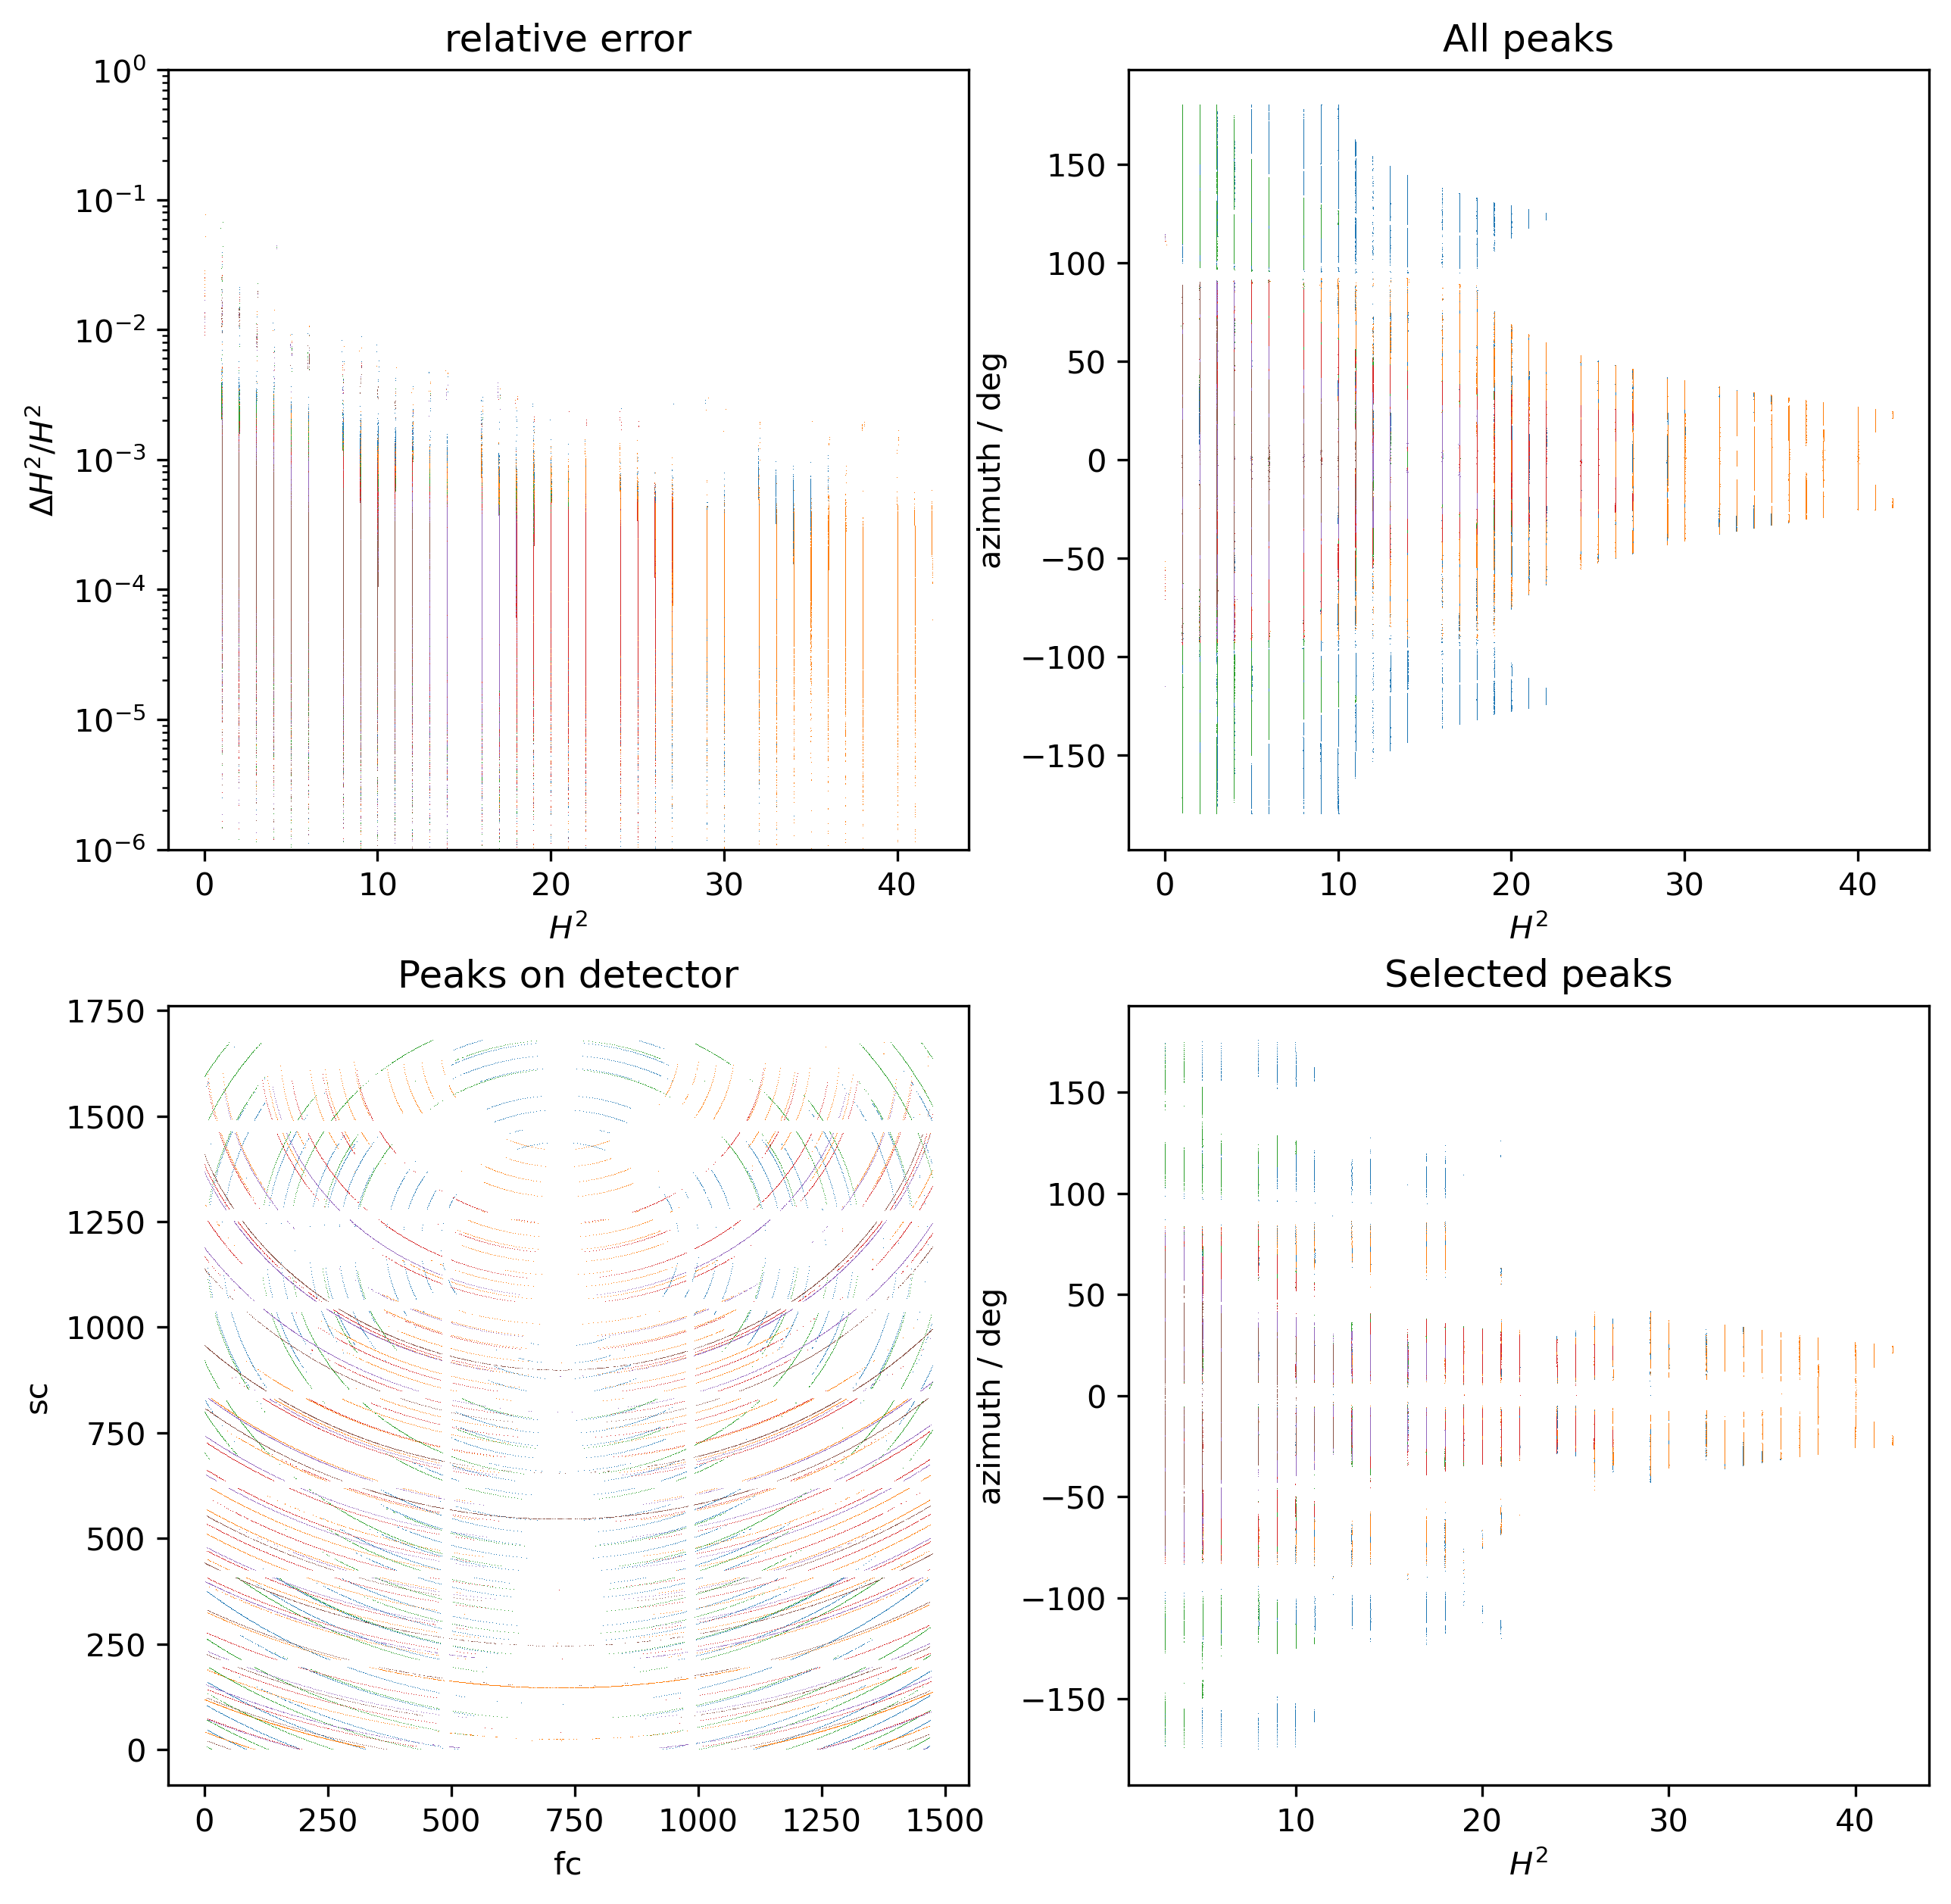

In [6]:
# created via moduleSpatialPeakSearch
f, ((a3, a4),(a1,a2)) = pl.subplots(2,2,figsize=(10,10),dpi = 300)
cf = {}

ds0 = a0*a0
for i,file in enumerate(files,1):
    # Load the peaks and parameters:
    basename = os.path.splitext(file)[0]
    basenamesub = basename.replace('_s','')
    fltfile = f'{basenamesub}.flt'
    c = columnfile(fltfile)
    c.parameters.loadparameters(file)
    c.updateGeometry()
    # Create column of frame number
    c.addcolumn(np.ones(c.nrows)*i,'frame')
    # (d*_obs)^2 / (a_0)^2 from cubic hkl to d-spacing formula
    c.addcolumn(np.ones(c.nrows)*c.ds**2*ds0,'hkl2')
    # nearest integers == fit target values
    c.addcolumn(np.round(c.hkl2),'ihkl2')
    # something like a strain
    se = abs( c.ihkl2 - c.hkl2 )/np.where( c.ihkl2 > 0, c.ihkl2, 1)
    etareplot = np.where(c.eta < 0, c.eta + 180, c.eta - 180)
    a3.plot(c.hkl2, se, ",")
    a4.plot(c.hkl2, etareplot, ",")
    c.filter((c.Number_of_pixels>7) & (c.ihkl2>2) &  (se<2e-3) )
    etareplot = np.where(c.eta < 0, c.eta + 180, c.eta - 180)
    a1.plot(c.fc,c.sc,',')
    a2.plot(c.hkl2,etareplot,',')
    cf[i] = c
a1.set(title='Peaks on detector', ylabel='sc', xlabel='fc')
a2.set(title='Selected peaks', ylabel='azimuth / deg', xlabel='$H^2$')
a3.set(yscale='log', ylim=(1e-6,1), title='relative error', ylabel='$\Delta H^2/H^2$', xlabel='$H^2$')
_ = a4.set(title='All peaks', ylabel='azimuth / deg', xlabel='$H^2$')


In [7]:
# put together all of the peaks:
allpks = np.concatenate( [cf[f].bigarray for f in frms], axis=1)
# ... and place them into an ImageD11 colummfile object
allc = c.copy()
allc.set_bigarray(allpks)
allc.nrows, np.sum([cf[f].nrows for f in frms])


(44189, 44189)

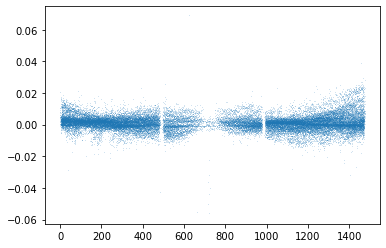

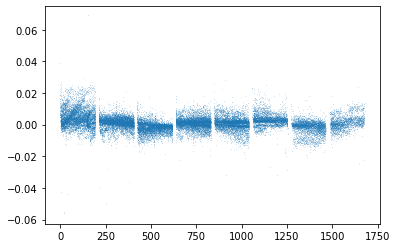

In [8]:
# Remove "bad" peaks from virtual shared pixels
#uncomment the following lines if it may be useful
#for col in virtualLinesx:
#    allc.filter(abs(allc.fc-col) > 2.1)
#for row in virtualLinesy:
#    allc.filter(abs(allc.sc-row)>2.1)
pl.figure(2)
pl.plot(allc.fc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)
pl.figure(3)
pl.plot(allc.sc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)

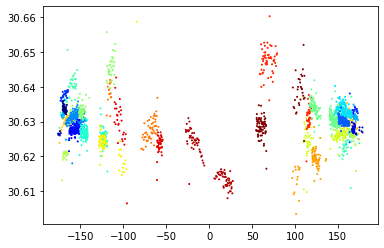

In [9]:
# just one ring, color by module
pl.figure(4)
m = allc.ihkl2 == 10
pl.scatter(allc.eta[m],allc.tth[m],c=allc.module[m], s = 1, cmap = 'jet')

In [10]:
frm = np.unique(allc.frame)
modu = np.unique(allc.module)
print(frm, modu)


[1. 2. 3. 4. 5. 6.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


In [11]:
# set up a fitting problem : these parameters will be fed to the calchkl2 routine below

# distance, tilts, centers for each image 
pars = [ ]
pnames = [ ]
for f in frm:
    pars.append( cf[f].parameters.get('distance') / a0 ) # distance scaled on lattice
    pnames.append( '%d:distance/a'%(f) )
    for pname in 'y_center z_center tilt_y tilt_z'.split():
        pars.append( cf[f].parameters.get(pname) )
        pnames.append( '%d:%s'%(f, pname) )

        
pars.append( a0 ) # effectively the wavelength
pnames.append( 'a0' )
framepars = len(pars)
nframes = len(cf.keys())


pars += [0. for i in range((no_modules-1)*3)] # 16 module centers and tilts, BUT LAST IS FIXED, 24 on pilatus2m
pnames += ["M[%d,%d]"%(i,j) for i in range(no_modules-1) for j in range(3) ]
for n,v in zip(pnames, pars):
    print(n,v)
# offset, rotation for each module

1:distance/a 33.441416963953586
1:y_center 719.9262471306008
1:z_center 1194.8714654963799
1:tilt_y 0.0013509344973839836
1:tilt_z 3.362282166081333e-05
2:distance/a 33.46828543790427
2:y_center 719.6710954274424
2:z_center 1660.2933737518072
2:tilt_y 0.0015514176362426326
2:tilt_z -5.5377803916094225e-05
3:distance/a 57.4855359804305
3:y_center 720.000637294442
3:z_center 1194.821749569254
3:tilt_y 0.0013962916502615785
3:tilt_z -0.0001276178436770946
4:distance/a 57.51167523481828
4:y_center 719.6964090413462
4:z_center 1659.9388356828035
4:tilt_y 0.0013406698036781415
4:tilt_z -0.00013193168980797534
5:distance/a 81.56524545317201
5:y_center 719.6935547893349
5:z_center 1659.9064073079587
5:tilt_y 0.0013608599557387883
5:tilt_z -0.00023268970486561806
6:distance/a 105.61347234254384
6:y_center 719.6028161107671
6:z_center 1659.8286210276224
6:tilt_y 0.0013259720862654144
6:tilt_z -0.00033619608299222624
a0 4.156826
M[0,0] 0.0
M[0,1] 0.0
M[0,2] 0.0
M[1,0] 0.0
M[1,1] 0.0
M[1,2] 0.0
M[

In [12]:
#detector module sizes - 513x512 for Eiger 4M, 487x195 for Pilatus2M



def module(a,i,j,fs=fs,ss=ss,fo=fo,so=so):
    #p = padding around the outside for debug
    '''
    i and j are module indexes. 
    '''
    f = fs*j + fo[j]
    s = ss*i + so[i]
    return a[s:s+ss,f:f+fs]

def module_center( i, j,fs=fs,ss=ss,so=so,fo=fo ):

    # print(i.dtype,j.dtype,j.shape)
    return so[i] + ss*(i+0.5), fo[j] + fs*(j+0.5)

def mp_last( pmods ):
    """ Compute the parameters of the last module from the previous ones 
    We set the sum of all modules to be zero
    """
    pallmods = np.array(list(pmods) + [0,0,0]).reshape( int(len(pmods)/3)+1, 3) 
    pallmods[-1,:] = -np.sum(pallmods, axis=0) # last module is fixed to make mean zero
    return pallmods
    
    
def do_spatial(s_raw, f_raw, m, modpars):
    """
    s_raw = co-ordinate in the slow pixel direction
    f_raw = co-ordinate in the fast pixel direction
    m = module for this peak (in the range 0,15 for Eiger4M)
    modpars = spatial parameters (offset_slow, offset_fast, angle_rad)
    """
    global noxmodules

    i = m // noxmodules
    j = m % noxmodules
    cs, cf = module_center( i, j )
    shift_s = np.array( modpars[:,0] )
    shift_f = np.array( modpars[:,1] )
    ds = s_raw[:] - cs + shift_s[m]
    df = f_raw[:] - cf + shift_f[m]
    rotates = modpars[:,2]
    sinr = np.sin(rotates)
    cosr = np.cos(rotates)
    dsr =  cosr[m] * ds  + sinr[m] * df
    dfr = -sinr[m] * ds  + cosr[m] * df
    sc = dsr + cs
    fc = dfr + cf
    return sc,fc    

def calchkl2( colf, *args ):
    """
    colf = columnfile (table) containing labelled peaks
    *args = parameters to be fitted
    """
    fpars = np.array(list(args))
    global framepars, frm, w # above
    modpars = mp_last(fpars[framepars:]) # make last module == sum of previous
    #
    ycalc = np.zeros(colf.nrows, float)
    # apply the current spatial correction
    m = colf.module[:].astype(int)
    sc, fc = do_spatial( colf.s_raw, colf.f_raw, m, modpars )
    

    e = 12.398419745832/w
    a0 = fpars[framepars-1]
    for k,rf in enumerate(frm):
        f = int(rf)
        lo = np.searchsorted( colf.frame, f )   # assume data still sorted by frame
        hi = np.searchsorted( colf.frame, f+1 )
        # compute x,y,z laboratory
        x,y,z = transform.compute_xyz_lab( (sc[lo:hi], fc[lo:hi]), 
                                               distance = fpars[k*5]*a0, # take out ds0 again
                                               y_center = fpars[k*5+1],
                                               z_center = fpars[k*5+2],
                                               y_size=pixy, z_size=pixz,
                                               tilt_y = fpars[k*5+3],
                                               tilt_z = fpars[k*5+4],
                                               tilt_x = 0,
                                               o11=1,o12=0,o21=0,o22=-1 )
        # radius:
        r = np.sqrt(y*y + z*z)
        # two theta:
        tthrad = np.arctan2(r, x)
        # wvln = 2*d*sin(th)
        # 1/d = 2*sin(th)/wvln
        # c.ds**2*ds0
        ds = 2*np.sin( tthrad/2 ) / w
        ycalc[lo:hi] = ds*ds*a0*a0
    scor = np.mean((ycalc - colf.ihkl2)**2)
    strain = (ycalc - colf.ihkl2)/colf.ihkl2  # approximately zero
    return strain

[]

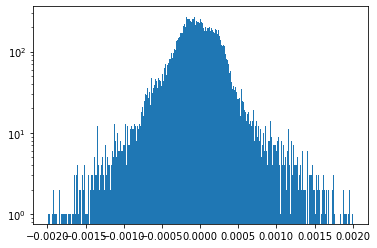

In [13]:
yc = calchkl2( allc, *pars )
pl.figure()
pl.hist(yc,bins=1024)
pl.semilogy()

In [14]:
avgi = allc.sum_intensity / allc.Number_of_pixels   # average intensity in a peak 
sigma = avgi/avgi.max()                             # relative weights

fpars, matrx = curve_fit( calchkl2,               # function to fit
                               allc,                    # 'x' argument to function 
                               np.zeros(allc.nrows),    # y_obs values (integer hkls)  
                               pars,                    # parameters to be fitted
                               sigma = sigma  )

Correlation above 80%
2:z_center 2:distance/a 0.85747193357788
3:distance/a 1:distance/a 0.9240165310713258
3:y_center 1:y_center 0.9069758356687139
3:tilt_z 1:tilt_z 0.8329639116547628
4:y_center 2:y_center 0.8166645659912192
4:z_center 4:distance/a 0.8556715977763112
4:tilt_y 2:tilt_y 0.887016529480014
4:tilt_z 2:tilt_z 0.8850388557742118
5:y_center 4:y_center 0.8176170052209538
5:z_center 5:distance/a 0.8714244932750351
5:tilt_y 4:tilt_y 0.853380327243375
5:tilt_z 2:tilt_z 0.8768069842723643
5:tilt_z 4:tilt_z 0.8703383340446793
6:y_center 5:y_center 0.8280007057607961
6:z_center 6:distance/a 0.8753502151647015
6:tilt_y 4:tilt_y 0.8053062883387946
6:tilt_y 5:tilt_y 0.8301598940285007
6:tilt_y 6:distance/a 0.8501118008755788
6:tilt_z 2:tilt_z 0.8907461802792007
6:tilt_z 4:tilt_z 0.8762930377216898
6:tilt_z 5:tilt_z 0.8863970926877218
a0 2:tilt_y -0.9059298827233101
M[0,2] M[0,0] -0.8876161251481204
M[2,2] M[2,0] 0.8938834011032981
M[3,2] M[3,0] -0.8141843874345375
M[4,0] M[1,0] 0.8637

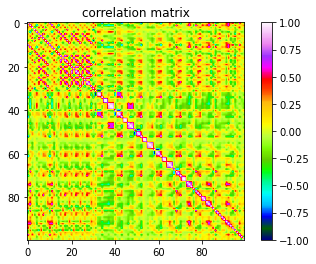

In [15]:
#print(fpars, matrx)
pl.figure()
corr = matrx.copy()
ser = np.sqrt(np.diag(corr))
corr = corr / ser 
corr = corr.T / ser
pl.imshow(corr, cmap='gist_ncar', vmin=-1)
pl.colorbar()
pl.title("correlation matrix")
print("Correlation above 80%")
for i in range(corr.shape[0]):
    for j in range(i-1):
        if abs(corr[i,j])>0.8:
            print(pnames[i],pnames[j],corr[i,j])

[]

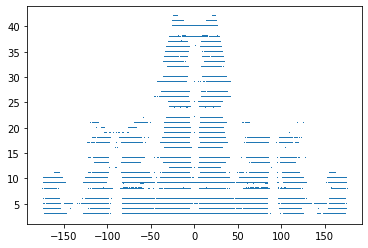

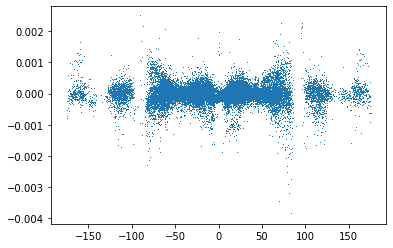

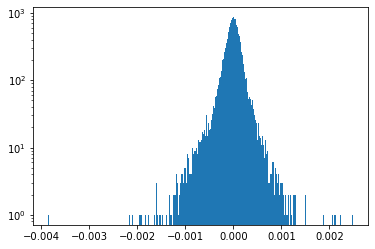

In [16]:
ycalc = calchkl2(allc, *fpars)
etareplot = np.where(allc.eta<0, allc.eta +180, allc.eta - 180)
pl.figure()
pl.plot(etareplot, ycalc*allc.ihkl2+allc.ihkl2, ",")
pl.figure()
pl.plot(etareplot, ycalc, ",")
pl.figure()
pl.hist( ycalc, bins=1024)
pl.semilogy()

In [17]:
allc.filter( abs(ycalc)<0.0003 )

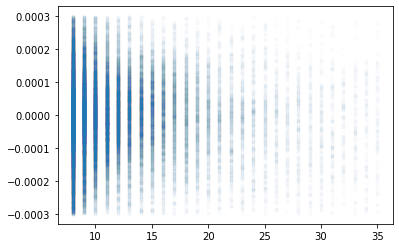

In [18]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.Number_of_pixels,ycalc,'.', alpha=0.01)

In [19]:
# repeat fitting with cleaned data
p2 = [p for p in fpars]  
fpars2, matrx2 = curve_fit( calchkl2, allc, np.zeros(allc.nrows), p2 )

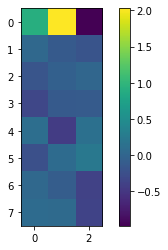

In [20]:
p16 = mp_last(fpars2[framepars:])
pl.figure()
array = np.empty(shape = (noymodules,noxmodules))
for mo in range(len(p16)):
    i = mo // noxmodules
    j = mo % noxmodules
    array[i,j] = p16[mo][1]
pl.imshow(array)
pl.colorbar()

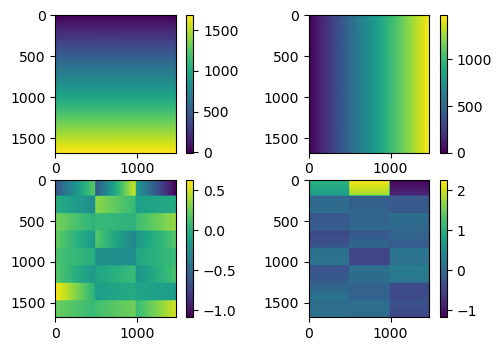

In [28]:
fig,((ax1,ax2),(ax3,ax4)) = pl.subplots(2,2,dpi = 100)
ax1o = ax1.imshow(sc)
fig.colorbar(ax1o,ax=ax1)

ax2o = ax2.imshow(fc)
fig.colorbar(ax2o,ax=ax2)

ax3o = ax3.imshow(ds)
fig.colorbar(ax3o,ax=ax3)

ax4o = ax4.imshow(df)
fig.colorbar(ax4o,ax=ax4)

In [29]:
np.savetxt("fitted_pilatus_pars2.dat",fpars2)
np.savetxt("fitted_pilatus_framepars2.dat",p16)

In [30]:
# Write spatially corrected files
a0 = fpars2[framepars-1]
for i,file in enumerate(files,1):
    p = read_par_file(file)
    k = i-1
    p.parameters.update( {'distance' : fpars2[k*5]*a0,
                          'y_center' : fpars2[k*5+1],
                          'z_center' : fpars2[k*5+2],
                          'tilt_y' : fpars2[k*5+3],
                          'tilt_z' : fpars2[k*5+4] } )
    p.saveparameters(file.replace('.par','_s.par'))

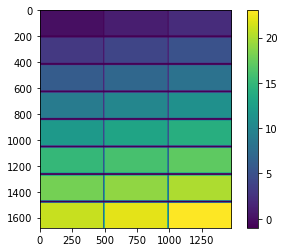

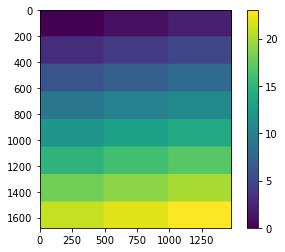

In [31]:
# Verify and create conventional distortion files
s, f = np.mgrid[0:cbfysize,0:cbfxsize]
m = np.zeros(s.shape, int)-1

for i in range(noymodules):
    for j in range(noxmodules):
        a = module(m,i,j)
        a[:,:] = i*noxmodules+j
# Make an image of which module is this pixel
pl.figure()
pl.imshow(m)
pl.colorbar()

for y,yg in zip(ygapedge,ygapsizes):
    m[y:y+yg//2,:] = m[y-1,:]
    m[y+yg//2:y+yg,:] = m[y+yg+1,:]

for x,xg in zip(xgapedge,xgapsizes):

    m[:, x:x+xg//2] = np.array([m[:, x-1]]*(xg//2)).transpose() #I was getting an error when trying to use a 1d array
    m[:, x+xg//2:x+xg] = np.array([m[:, x+xg+1]]*(xg-xg//2)).transpose()
    
    
# verify we did not mess up the real pixels:
for i in range(noymodules):
    for j in range(noxmodules):
        a = module(m,i,j)
        assert((a[:,:] == i*noxmodules+j).all())
pl.figure()
pl.imshow(m)
pl.colorbar()

In [32]:
# full image spatial:
sc,fc = do_spatial(s.ravel(),f.ravel(),m.ravel(), p16)
sc.shape=s.shape
fc.shape=f.shape
ds = sc - s      # LUT
df = fc - f      # 

In [33]:
fabio.edfimage.edfimage((fc-f).astype(np.float32)).write("e2dx.edf")
fabio.edfimage.edfimage((sc-s).astype(np.float32)).write("e2dy.edf")

In [34]:
pilatusPixelCorners = np.empty(shape = (*cbf.shape,4,3))

       
print(pilatusPixelCorners.shape)


(1679, 1475, 4, 3)


In [35]:
def siground(n,figs):
    order = int(np.log10(n))
    return(round(n,figs-order))


In [36]:
ps = siground(pixy/1000,3) #pyFAI uses meters, while imageD11 uses mm
print(f'pixel size = {ps}')
x = pilatusPixelCorners[:]
sc,fc = do_spatial(s.ravel()-0.5,f.ravel()-0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,0,1] = sc*ps
x[:,:,0,2] = fc*ps

sc,fc = do_spatial(s.ravel()+0.5,f.ravel()-0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,1,1] = sc*ps
x[:,:,1,2] = fc*ps

sc,fc = do_spatial(s.ravel()+0.5,f.ravel()+0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,2,1] = sc*ps
x[:,:,2,2] = fc*ps

sc,fc = do_spatial(s.ravel()-0.5,f.ravel()+0.5,m.ravel(), p16)
sc=np.reshape(sc,s.shape)
fc=np.reshape(fc,f.shape)
x[:,:,3,1] = sc*ps
x[:,:,3,2] = fc*ps
pilatusPixelCorners[:]=x
pilatusPixelCorners

pixel size = 0.000172


array([[[[ 0.00000000e+00, -1.96805663e-04,  9.88907386e-05],
         [ 0.00000000e+00, -2.48059267e-05,  9.85895729e-05],
         [ 0.00000000e+00, -2.45047611e-05,  2.70589309e-04],
         [ 0.00000000e+00, -1.96504497e-04,  2.70890475e-04]],

        [[ 0.00000000e+00, -1.96504497e-04,  2.70890475e-04],
         [ 0.00000000e+00, -2.45047611e-05,  2.70589309e-04],
         [ 0.00000000e+00, -2.42035954e-05,  4.42589046e-04],
         [ 0.00000000e+00, -1.96203332e-04,  4.42890211e-04]],

        [[ 0.00000000e+00, -1.96203332e-04,  4.42890211e-04],
         [ 0.00000000e+00, -2.42035954e-05,  4.42589046e-04],
         [ 0.00000000e+00, -2.39024297e-05,  6.14588782e-04],
         [ 0.00000000e+00, -1.95902166e-04,  6.14889948e-04]],

        ...,

        [[ 0.00000000e+00, -2.72366583e-04,  2.52896704e-01],
         [ 0.00000000e+00, -1.00366903e-04,  2.52897036e-01],
         [ 0.00000000e+00, -1.00698833e-04,  2.53069035e-01],
         [ 0.00000000e+00, -2.72698512e-04,  2.530

In [37]:
y0 = pilatusPixelCorners[0,0,0,1]
x0 = pilatusPixelCorners[0,0,0,2]
print(x0,y0,ps)
pixelPlot = np.empty(shape = (*cbf.shape,2))

pixelPlot[:,:,0] = pilatusPixelCorners[:,:,0,1] - ps*s - y0
pixelPlot[:,:,1] = pilatusPixelCorners[:,:,0,2] - ps*f - x0

9.889073860682606e-05 -0.00019680566306482075 0.000172


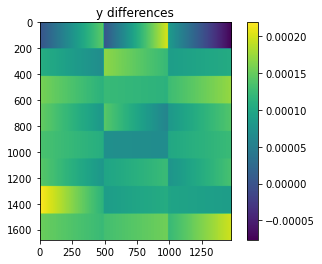

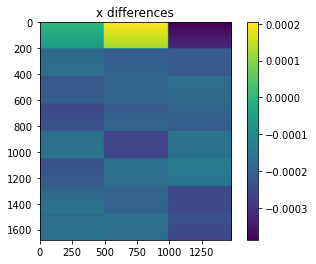

In [38]:
pl.figure()
pl.imshow(pixelPlot[:,:,0])
pl.colorbar()
pl.title('y differences')
pl.figure()
pl.title('x differences')
pl.imshow(pixelPlot[:,:,1])
pl.colorbar()


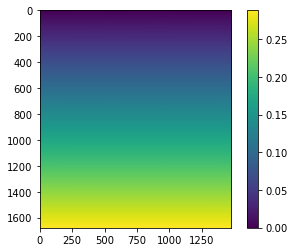

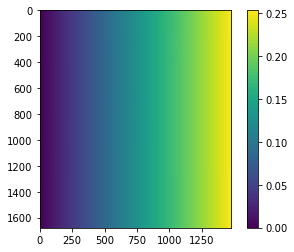

In [39]:
pl.figure()
pl.imshow(pilatusPixelCorners[:,:,0,1])
pl.colorbar()
pl.figure()
pl.imshow(pilatusPixelCorners[:,:,0,2])
pl.colorbar()

#### To use the correction in pyFAI I found I had to run through pyFAI-calib2 with the standard detector as normal, then after fitting, load the custom detector file (.h5), and refit the parameters. For some reason pyFAI couldn't automatically find the rings and really struggled to find a good initial fit when loading the custom detector file at first. 
#### It gave a ~10% improvement in rms on 3 images I tried, but with certain diffraction rings the impact was very visible.

In [40]:
#save detector for pyFAI
import pyFAI
detector = pyFAI.detector_factory('Pilatus2m')
detector.set_pixel_corners(pilatusPixelCorners)
detector.save('pilatusPixelCorrections.h5')

In [41]:
help(detector.set_offset_files)

Help on method set_offset_files in module pyFAI.detectors._dectris:

set_offset_files(x_offset_file=None, y_offset_file=None) method of pyFAI.detectors._dectris.Pilatus2M instance



In [42]:
print(pilatusPixelCorners[0,0])
print(pilatusPixelCorners[1,1])

[[ 0.00000000e+00 -1.96805663e-04  9.88907386e-05]
 [ 0.00000000e+00 -2.48059267e-05  9.85895729e-05]
 [ 0.00000000e+00 -2.45047611e-05  2.70589309e-04]
 [ 0.00000000e+00 -1.96504497e-04  2.70890475e-04]]
[[ 0.00000000e+00 -2.45047611e-05  2.70589309e-04]
 [ 0.00000000e+00  1.47494975e-04  2.70288144e-04]
 [ 0.00000000e+00  1.47796141e-04  4.42287880e-04]
 [ 0.00000000e+00 -2.42035954e-05  4.42589046e-04]]


In [43]:
t = transformer()
index = 1
t.loadfiltered(flts[index])
print(flts[index])
c = t.colfile
c.sc[:] = ds[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.s_raw[:]
c.fc[:] = df[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.f_raw[:]
t.loadfileparameters(flts[index].replace('.flt','_s.par'))
t.compute_tth_eta()
t.addcellpeaks()
t.parameterobj.varylist.append('wavelength')
t.fit()

pilatusSpatial\lab6_000_00_0001p.flt
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 248   Best = 20.614219   Worst = 20.614525                     [1660.2534669411284, 719.5988350260852, 139.17280444402897, 1.065400465051797e-05, 0.0007217224379687066, 0.6939215625075332]


In [44]:
t.fit_tolerance=0.005
for i in range(3):
    t.addcellpeaks() 
    t.fit()
    t.compute_tth_eta()
t.addcellpeaks() # wavelength is fitted

Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 65   Best = 19.105128   Worst = 19.105402                       [1660.2491065787633, 719.5989743749699, 139.17177538910218, 9.902509987747282e-06, 0.0007197106217792921, 0.6939209729840934]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 62   Best = 19.102223   Worst = 19.102441                    [1660.252130424382, 719.5991762338069, 139.17429324527774, 9.534251730977863e-06, 0.0007033771049589656, 0.6939093998151156]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 62   Best = 19.102223   Worst = 19.102441                     [1660.252130424382, 719.5991762338069, 139.17429324527774, 9.534251730977863e-06, 0.0007033771049589656, 0.6939093998151156]


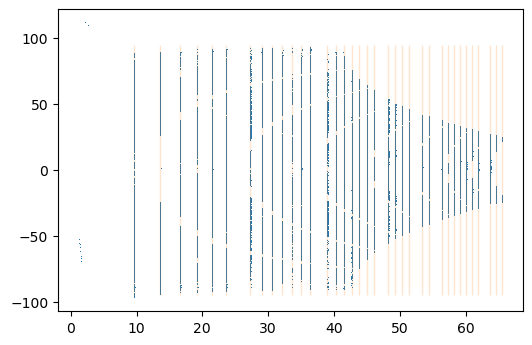

In [45]:
%matplotlib inline
pl.figure(dpi = 100)
etareplot = np.where(t.colfile.eta < 0, t.colfile.eta+180,t.colfile.eta-180)
pl.plot(t.colfile.tth,etareplot,",")
pl.plot(t.theorytth,np.zeros(len(t.theorytth)),"|",ms=180,alpha=0.2)

In [46]:
12.3984/t.parameterobj.parameters['wavelength']

17.867462241185113

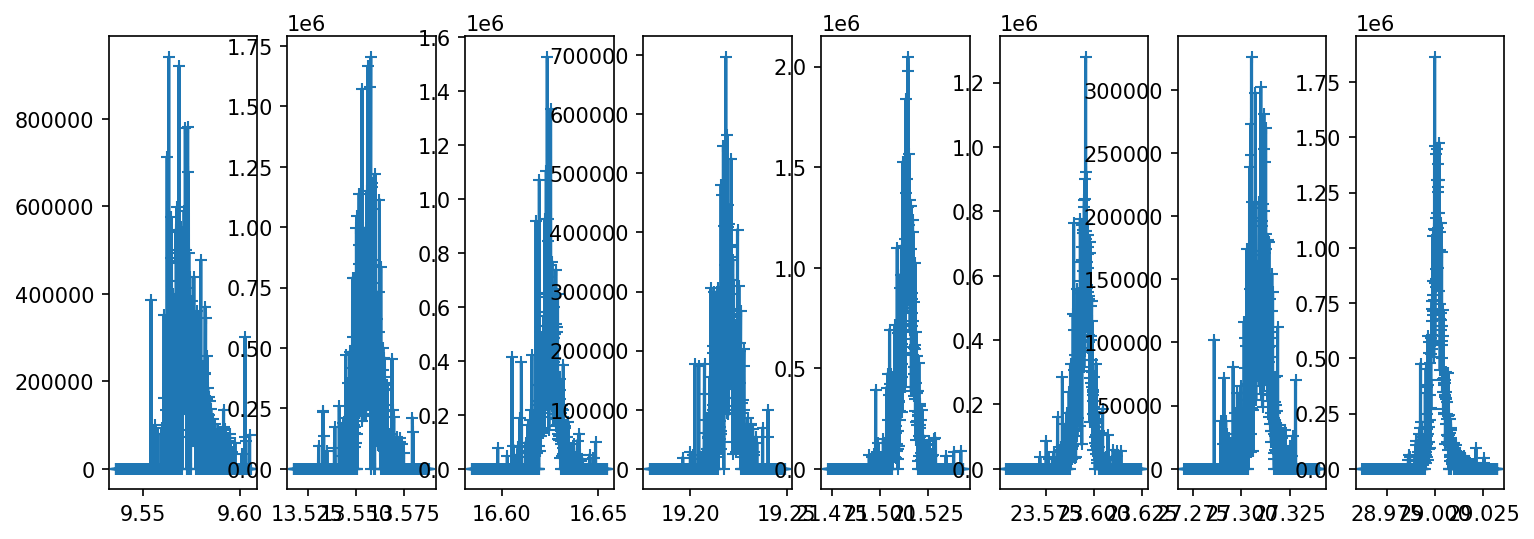

In [47]:
h,b = np.histogram(c.tth,weights=c.sum_intensity,bins=np.arange(0,c.tth.max(),0.0001))
pl.figure()
pl.plot(b[1:],h,'+-')
%matplotlib inline
fig,a=pl.subplots(1,8,figsize=(12,4),dpi = 150)
for i,tth in enumerate(t.theorytth[:8]):
    lo = np.searchsorted(b,tth-0.04)
    hi = np.searchsorted(b,tth+0.03)
    a[i].plot( b[lo:hi], h[lo:hi], "+-" )

In [48]:
c.parameters = t.parameterobj

In [49]:
c.updateGeometry()

C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_14552\3814098877.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rcalc = np.zeros(r.shape,np.float)
C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_14552\3814098877.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()


tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev
9.57567   335 309.841 0.119 0.091 0.099
13.55790   421 438.772 0.106 0.087 0.089
16.62450   605 538.075 0.090 0.067 0.074
19.21903   555 622.072 0.090 0.067 0.075
21.51309   917 696.326 0.075 0.053 0.061
23.59458  1006 763.684 0.079 0.055 0.064
27.31038   790 883.914 0.100 0.076 0.084
29.00222  1282 938.650 0.066 0.047 0.054
30.60837  1375 990.644 0.068 0.050 0.056
32.14175  1339 1040.282 0.082 0.062 0.068
33.61242   247 1087.889 0.103 0.084 0.087
35.02836  1336 1133.735 0.095 0.073 0.079
36.39604  1939 1178.020 0.097 0.077 0.082
39.00707   591 1262.469 0.112 0.087 0.094
40.25864  1916 1303.017 0.075 0.053 0.062
41.47871  1942 1342.502 0.083 0.062 0.069
42.67008  1430 1381.050 0.095 0.071 0.079
43.83516  1732 1418.757 0.095 0.071 0.079
44.97606  1965 1455.671 0.071 0.052 0.059
46.09467  1591 1491.873 0.090 0.068 0.075
48.27144  1461 1562.293 0.103 0.080 0.086
49.33243  1531 1596.649 0.111 0.091 0.093
50.37680  1879 1630.

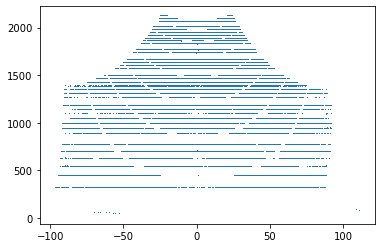

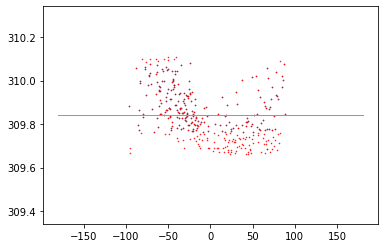

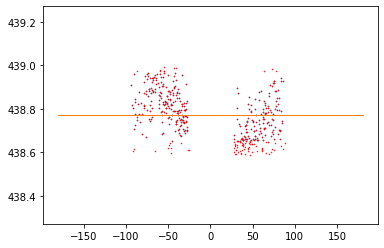

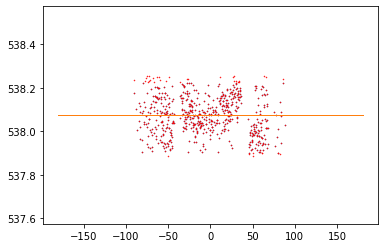

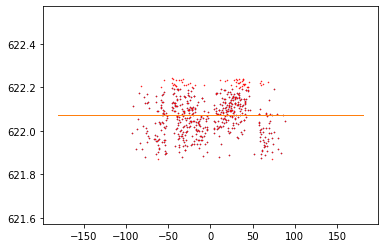

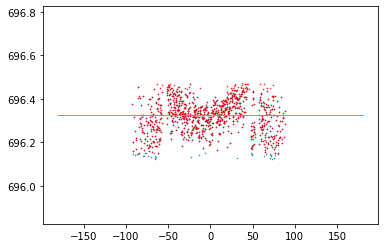

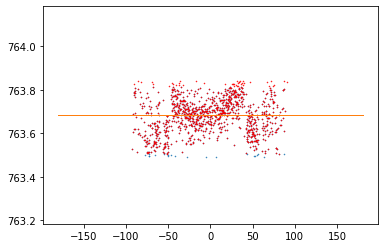

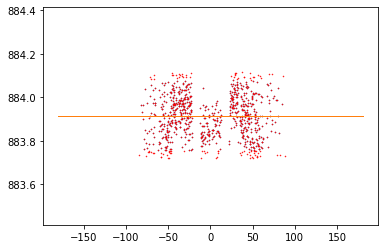

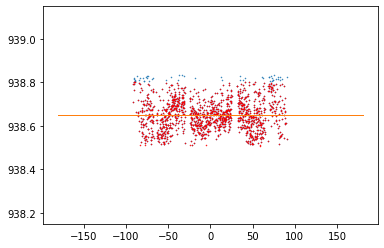

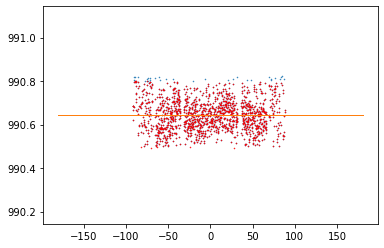

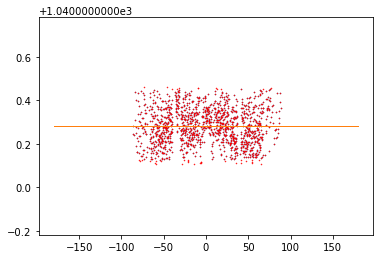

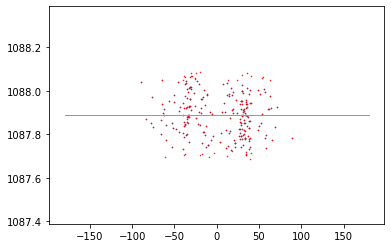

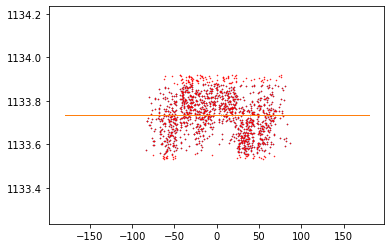

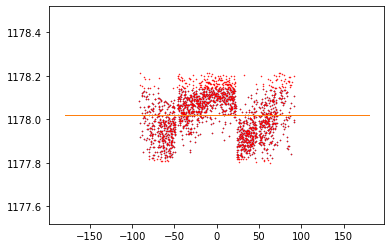

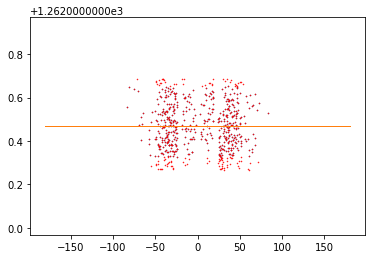

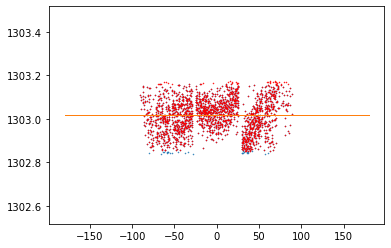

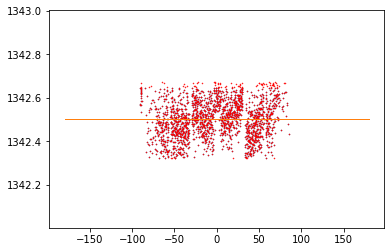

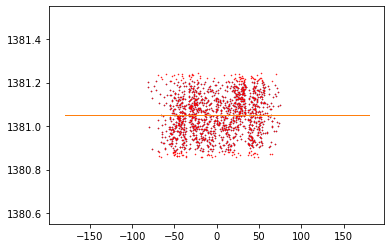

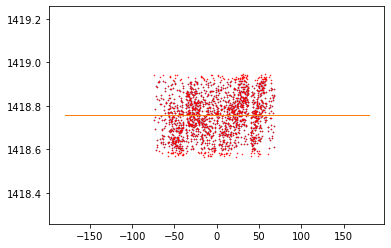

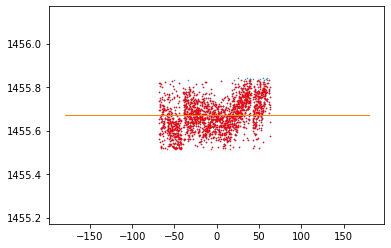

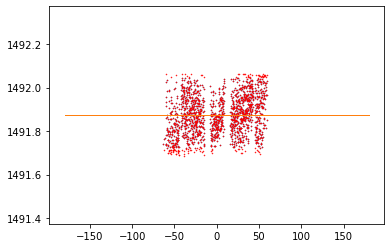

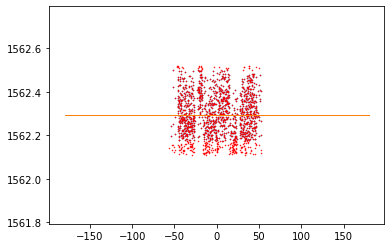

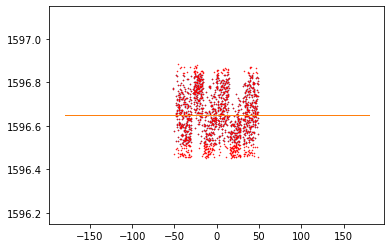

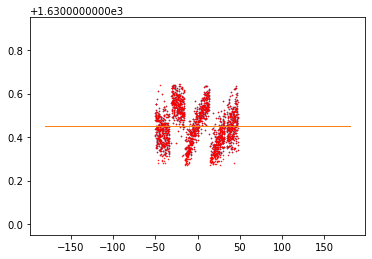

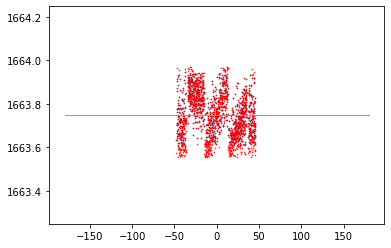

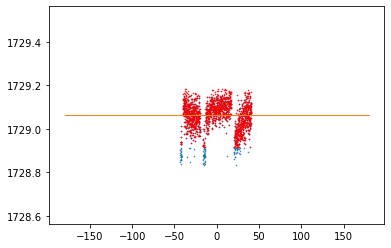

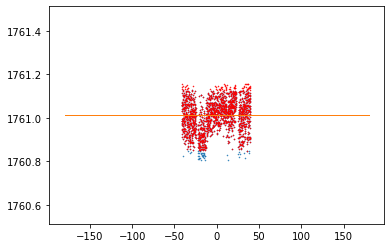

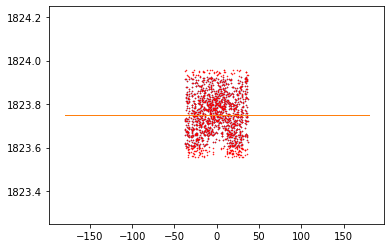

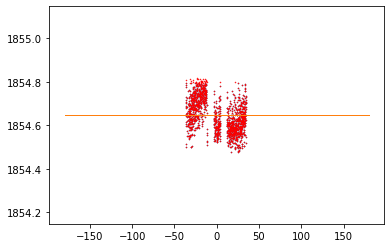

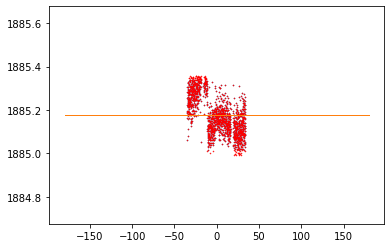

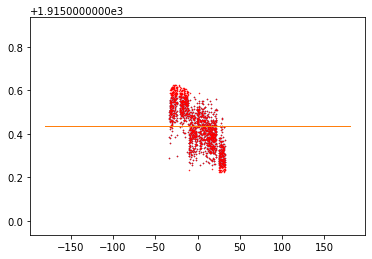

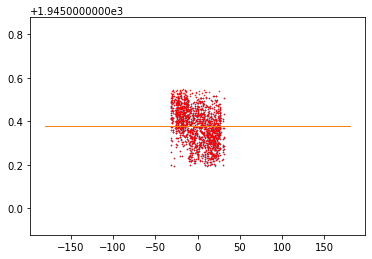

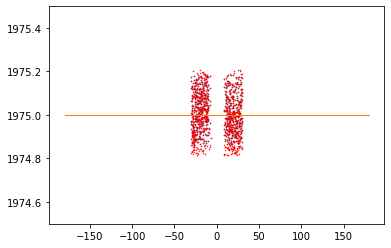

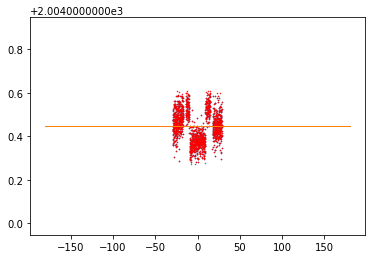

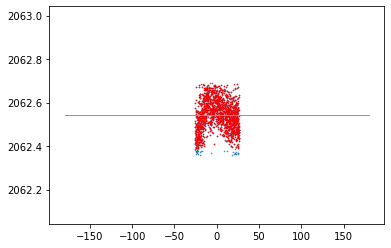

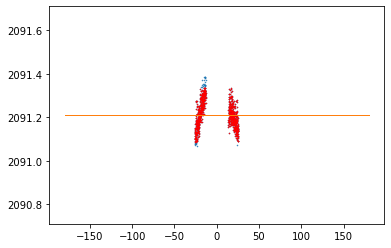

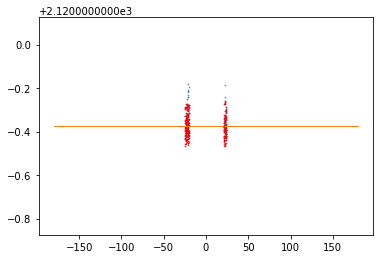

In [50]:
%matplotlib inline
c.titles
r = np.arctan2(np.sqrt(c.yl*c.yl+c.zl*c.zl), c.xl)*c.xl.mean()/0.075
pl.figure()
etareplot = np.where(c.eta < 0, c.eta + 180, c.eta - 180) 
pl.plot(etareplot,r,",")
rcalc = np.zeros(r.shape,np.float)
lines = ["tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev",]
for tth in t.theorytth:
    sel = np.abs(c.tth - tth)<0.005
    pks = r[sel]
    if sel.sum()==0:
        continue
    rc = pks.mean()
    mad = np.median(abs(r[sel] - rc))
    msel = np.abs( r - rc ) < mad * 3
    pks = r[msel]
    rc = r[msel].mean()
    pl.figure()
    etareplot = np.where(c.eta[sel] < 0, c.eta[sel] +180, c.eta[sel] - 180)
    etareplotm = np.where(c.eta[msel] < 0, c.eta[msel] +180, c.eta[msel] - 180)
    pl.plot( etareplot, r[sel], '.', ms=1 )
    pl.plot( etareplotm, r[msel], '.r', ms=1 )
    pl.plot( (-180, 180), [rc, rc], '-', lw=1 )
    pl.ylim(rc-0.5, rc+0.5)
    ad = abs(pks-pks.mean())
    lines.append("%.5f %5d %.3f %.3f %.3f %.3f"%(
        tth,msel.sum(),pks.mean(),pks.std(),np.median(ad),np.mean(ad)))
for line in lines:
    print(line)

In [51]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))

Output created on Thu Aug 11 13:42:52 2022
Total runtime 1338.657 /s
